# Lab 4 - Neural Network Classifier Using Simple Word Embeddings



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [0]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential


Using TensorFlow backend.


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [0]:
imdb = keras.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

We now can start playing around with the data, let’s first see the length:

In [0]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [0]:
 X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [0]:

word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [0]:

word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [0]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [0]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [0]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [0]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [0]:
print(X_train_enc[1])


[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


### Neural Network model using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [0]:
# put your code here
model = Sequential()
model.add(OneHot(input_dim=VOCAB_SIZE,input_length=MAX_SEQUENCE_LENGTH))  #one hot layer
model.add(GlobalAveragePooling1DMasked())   #average of word vector
model.add(Dense(units=16))                  #fully conected layer with 16 units
model.add(Dense(1,activation='sigmoid'))

### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [0]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [0]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)




Train on 15000 samples, validate on 10000 samples
Epoch 1/40





15000/15000 [==============================] - 16s 1ms/step - loss: 0.6921 - acc: 0.5441 - val_loss: 0.6911 - val_acc: 0.4991
Epoch 2/40
15000/15000 [==============================] - 6s 423us/step - loss: 0.6895 - acc: 0.5655 - val_loss: 0.6883 - val_acc: 0.6554
Epoch 3/40
15000/15000 [==============================] - 6s 423us/step - loss: 0.6865 - acc: 0.6395 - val_loss: 0.6852 - val_acc: 0.6579
Epoch 4/40
15000/15000 [==============================] - 6s 423us/step - loss: 0.6827 - acc: 0.6617 - val_loss: 0.6814 - val_acc: 0.6632
Epoch 5/40
15000/15000 [==============================] - 6s 419us/step - loss: 0.6783 - acc: 0.6745 - val_loss: 0.6768 - val_acc: 0.6700
Epoch 6/40
15000/15000 [==============================] - 6s 419us/step - loss: 0.6734 - acc: 0.6779 - val_loss: 0.6722 - val_acc: 0.6710
Epoch 7/40
15000/15000 [==============================] - 6s 419us/step - loss: 0.6679 - acc: 0.6827 - val_loss: 0.

### Evaluating the model

To evaulate the model on test data:

In [0]:
results = model.evaluate(X_test_enc, y_test)

25000/25000 [==============================] - 7s 297us/step


In [0]:
print(results)
# loss, accuracay 

[0.5341577560806274, 0.74236]


In [0]:
#sanity check
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 10000)        0         
_________________________________________________________________
global_average_pooling1d_mas (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Our first model accuracy using one-hot vectors is 0.742 (74%)






### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

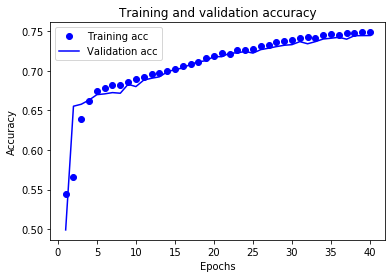

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Neural Network model using word embeddings

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [0]:
VOCAB_SIZE= 10000

# put the code here

model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE,100))  #Embedding layer 
model2.add(GlobalAveragePooling1DMasked())   #average of word vector
model2.add(Dense(units=16))                  #fully conected layer with 16 units
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test_enc, y_test)
print(results)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 42us/step - loss: 0.6880 - acc: 0.6141 - val_loss: 0.6804 - val_acc: 0.6448
Epoch 2/40
15000/15000 [==============================] - 0s 23us/step - loss: 0.6616 - acc: 0.7122 - val_loss: 0.6394 - val_acc: 0.7414
Epoch 3/40
15000/15000 [==============================] - 0s 23us/step - loss: 0.5993 - acc: 0.7691 - val_loss: 0.5678 - val_acc: 0.7740
Epoch 4/40
15000/15000 [==============================] - 0s 22us/step - loss: 0.5123 - acc: 0.8093 - val_loss: 0.4844 - val_acc: 0.8100
Epoch 5/40
15000/15000 [==============================] - 0s 23us/step - loss: 0.4248 - acc: 0.8485 - val_loss: 0.4139 - val_acc: 0.8438
Epoch 6/40
15000/15000 [==============================] - 0s 23us/step - loss: 0.3566 - acc: 0.8745 - val_loss: 0.3685 - val_acc: 0.8580
Epoch 7/40
15000/15000 [==============================] - 0s 22us/step - loss: 0.3092 - acc: 0.8897 - val_loss: 0.3381 - val_acc

In [0]:
results = model2.evaluate(X_test_enc, y_test)

25000/25000 [==============================] - 1s 39us/step


In [0]:
print (results)

[0.5766747018527985, 0.85488]


In [0]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


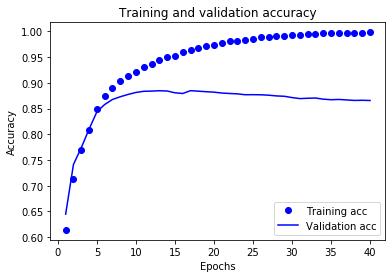

In [0]:
import matplotlib.pyplot as plt

history_dict = history2.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

### Using pre-trained word embeddings

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [0]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [0]:
from keras.initializers import Constant
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We freeze the weights. To create the model:

In [0]:
# put the code here
wordToIndex, indexToWord, wordToGlove = readGloveFile('drive/My Drive/Colab Notebooks/glove.6B.300d.txt')
model3 = Sequential()
model3.add(createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,False)) #setting isTrainable to true 
model3.add(GlobalAveragePooling1DMasked())   #average of word vector
model3.add(Dense(units=16))                  #fully conected layer with 16 units

### Adding another hidden layer to the network

In model3, we only add another dense layer to see if that improves the performance.

In [0]:
# put your code here
model3.add(Dense(16))   #adding extra layer 
model3.add(Dense(1,activation='sigmoid')) #output layer

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model3.evaluate(X_test_enc, y_test)
print(results)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 10s 653us/step - loss: 0.6837 - acc: 0.5689 - val_loss: 0.6681 - val_acc: 0.6229
Epoch 2/40
15000/15000 [==============================] - 5s 308us/step - loss: 0.6378 - acc: 0.6712 - val_loss: 0.6015 - val_acc: 0.7008
Epoch 3/40
15000/15000 [==============================] - 5s 307us/step - loss: 0.5339 - acc: 0.7568 - val_loss: 0.4771 - val_acc: 0.7947
Epoch 4/40
15000/15000 [==============================] - 5s 307us/step - loss: 0.4085 - acc: 0.8345 - val_loss: 0.3834 - val_acc: 0.8435
Epoch 5/40
15000/15000 [==============================] - 5s 306us/step - loss: 0.3194 - acc: 0.8736 - val_loss: 0.3374 - val_acc: 0.8632
Epoch 6/40
15000/15000 [==============================] - 5s 306us/step - loss: 0.2632 - acc: 0.8974 - val_loss: 0.3170 - val_acc: 0.8709
Epoch 7/40
15000/15000 [==============================] - 5s 307us/step - loss: 0.2214 - acc: 0.9155 - val_loss: 0.3002 -

In [0]:
model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 120,005,405
Trainable params: 120,005,405
Non-trainable params: 0
_________________________________________________________________


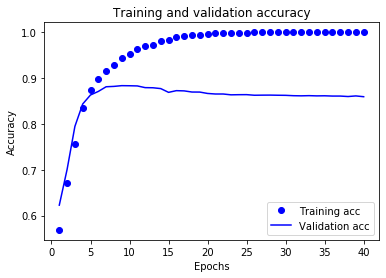

In [0]:
import matplotlib.pyplot as plt

history_dict = history3.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The accuracy of model3 with an additional layer is 85%. Adding more layers can help you to extract more features. But we can do that upto a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in some or the other form like false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---



This tutorial is substantially based on this document:
https://www.tensorflow.org/tutorials/keras/basic_text_classification

To read more about Sequential APIs you can go to: https://keras.io/getting-started/sequential-model-guide/

The one-hot word vector layer is taken from:
https://fdalvi.github.io/blog/2018-04-07-keras-sequential-onehot/
